In [1]:
import matplotlib.pyplot as plt
import polars as pl

In [2]:
ad_posts = pl.read_csv("/home/deniskirbaba/Documents/influai-data/ad_text.csv")

In [3]:
ad_posts

id,raw_text
i64,str
7719933,"""👀 ICML 2024 глазами ML-лидов Я…"
7719924,"""🎉 Коворкинг Яндекса на крыше М…"
7719923,"""👀 Показываем зумеров глазами з…"
7719914,"""🔥 Яндекс Х Epic Growth Confere…"
7719559,"""💫 Стартует новый сезон трениро…"
…,…
7719936,"""💫 В гармонии с кодом и природо…"
7719964,"""📎 Роман Елизаров о 20-летнем о…"
7719955,"""📕 Виртуальный рассказчик Букме…"


## Analyze length

In [4]:
text_length = ad_posts.map_rows(lambda x: len(x[1]))

In [5]:
text_length.describe()

statistic,map
str,f64
"""count""",177373.0
"""null_count""",0.0
"""mean""",658.048209
"""std""",633.397479
"""min""",1.0
"""25%""",207.0
"""50%""",459.0
"""75%""",895.0
"""max""",4096.0


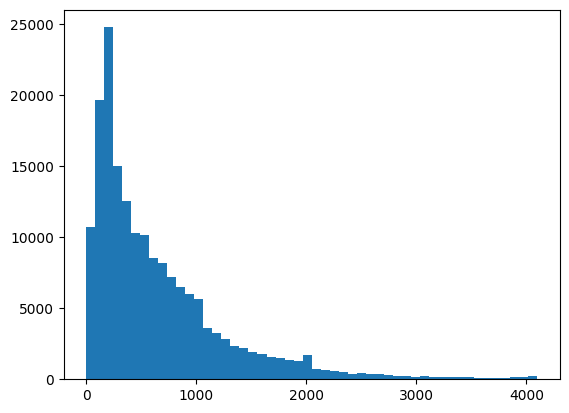

In [6]:
plt.hist(text_length, bins=50);

## Analyze tokens

In [7]:
from transformers import AutoTokenizer

/home/deniskirbaba/miniconda3/envs/influai-emb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
model_name = "intfloat/multilingual-e5-large-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
tok_texts = tokenizer(
    ad_posts["raw_text"].to_list(),
    padding=False,
    truncation=False,
    return_tensors="np",
    verbose=True,
)

Token indices sequence length is longer than the specified maximum sequence length for this model (862 > 512). Running this sequence through the model will result in indexing errors


In [19]:
tok_length = [len(ids) for ids in tok_texts.data["input_ids"]]
tok_length_pl = pl.DataFrame(tok_length, schema=["tok_len"], orient="row")
tok_length_pl

tok_len
i64
136
255
196
405
175
…
308
187
174


In [20]:
tok_length_pl.describe()

statistic,tok_len
str,f64
"""count""",177373.0
"""null_count""",0.0
"""mean""",185.551702
"""std""",160.212755
"""min""",4.0
"""25%""",74.0
"""50%""",139.0
"""75%""",246.0
"""max""",1526.0


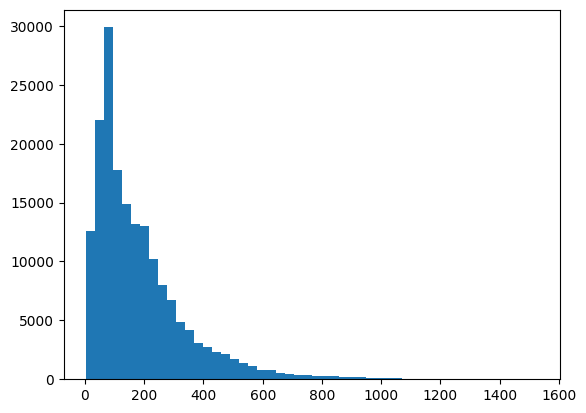

In [ ]:
plt.hist(tok_length_pl, bins=50);

In [28]:
len(tok_length_pl.filter(pl.col("tok_len") > 514)) / len(tok_length_pl) * 100

4.696317928884328

Длина контекста у модели = 514 токенов. Меньше 5% постов будет обрезано, что удовлетворительно.

Также стоит учитывать, что модели `intfloat/multilingual-e5-large-instruct` для каждого текста надо подавать промпт для большей эффективности, поэтому число обрезанных постов немного возрастет. Проверим насколько.

In [32]:
possible_prompts = [
    {
        "prompt_for_ad_emb": "На основе рекламного текста опиши ключевые интересы, ценности и потребности целевой аудитории, которая заинтересуется этой рекламой.",
        "prompt_for_channel_emb": "Проанализируй название, описание и посты Telegram-канала и определи ключевые интересы, ценности и потребности его аудитории.",
    },
    {
        "prompt_for_ad_emb": "По рекламному тексту сформируй профиль идеального Telegram-канала для размещения этой рекламы.",
        "prompt_for_channel_emb": "Проанализировав данные Telegram-канала, опиши его типичный профиль (тематика, аудитория, тон общения).",
    },
    {
        "prompt_for_ad_emb": "Изучив текст рекламы, определи, какие тематики каналов и форматы контента лучше всего подойдут для её размещения.",
        "prompt_for_channel_emb": "На основе данных о Telegram-канале, опиши его основные тематики и форматы контента.",
    },
    {
        "prompt_for_ad_emb": "Какие характеристики Telegram-канала (тематика, тональность, аудитория) обеспечат максимальную эффективность этой рекламы?",
        "prompt_for_channel_emb": "На основе информации о Telegram-канале, выдели его ключевые характеристики (тематика, тональность, аудитория).",
    },
    {
        "prompt_for_ad_emb": "Сформулируй требования к Telegram-каналу, который обеспечит успешное размещение данной рекламы (тематика, тип аудитории, охват).",
        "prompt_for_channel_emb": "Опиши Telegram-канал, основываясь на его названии, описании и содержании постов (тематика, аудитория, активность).",
    },
    {
        "prompt_for_ad_emb": "Какие особенности Telegram-канала помогут данной рекламе достичь наибольшего отклика?",
        "prompt_for_channel_emb": "Проанализируй Telegram-канал и опиши его особенности, которые могут привлекать аудиторию (уникальность, стиль подачи).",
    },
    {
        "prompt_for_ad_emb": "Определи ключевые слова и темы, которые соответствуют тексту рекламы и могут быть найдены в эффективных Telegram-каналах.",
        "prompt_for_channel_emb": "На основе данных о Telegram-канале выдели ключевые слова и основные темы его контента.",
    },
]

In [33]:
ad_prompts_tok = tokenizer(
    [prompts["prompt_for_ad_emb"] for prompts in possible_prompts],
    padding=False,
    truncation=False,
    return_tensors="np",
    verbose=True,
)

In [34]:
[len(ids) for ids in ad_prompts_tok.data["input_ids"]]

[30, 23, 29, 27, 36, 21, 31]

In [36]:
len(tok_length_pl.filter(pl.col("tok_len") > (514 - 30))) / len(tok_length_pl) * 100

5.6688447508921875

Процент обрезанных постов увеличился незначительно.